# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [12]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (144.5, 146.5)
LAT_LIMITS = (24.5, 26.5) 
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2025-05-12T00:00:00", "2025-05-13T00:00:00"]

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
data_dir = os.path.join('../', 'example_data', 'himawari_tutorial_02')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

##### Retrieve the required complete Himawari data files

By default this function will not overwrite existing files of the same name. 

This cell only needs to be run once. 

In [ ]:
# Download the data (note: this earthaccess function may not error if the file directory is not accessible)
himawari.get_sst_series_nasa(time_lims, data_dir)

In [ ]:
# Crop himawari files
crop_app = 'tutorial_02'

# Setting ow=True will delete the original files after cropping (can also just set file_app='')
himawari.crop_sst_series_nasa(data_dir, time_lims, ll_box, file_app=crop_app, overwrite=True)

In [14]:
# Load the data (if the timeseries is long you can save this dataset for loading later)
ds = himawari.process_sst_series(data_dir, time_lims, ll_box, file_app=crop_app)
ds

  Finished processing for 2025-05-12T00:00:00
  Finished processing for 2025-05-12T01:00:00
  Finished processing for 2025-05-12T02:00:00
  Finished processing for 2025-05-12T03:00:00
  Finished processing for 2025-05-12T04:00:00
  Finished processing for 2025-05-12T05:00:00
  Finished processing for 2025-05-12T06:00:00
  Finished processing for 2025-05-12T07:00:00
  Finished processing for 2025-05-12T08:00:00
  Finished processing for 2025-05-12T09:00:00
  Finished processing for 2025-05-12T10:00:00
  Finished processing for 2025-05-12T11:00:00
  Finished processing for 2025-05-12T12:00:00
  Finished processing for 2025-05-12T13:00:00
  Finished processing for 2025-05-12T14:00:00
  Finished processing for 2025-05-12T15:00:00
  Finished processing for 2025-05-12T16:00:00
  Finished processing for 2025-05-12T17:00:00
  Finished processing for 2025-05-12T18:00:00
  Finished processing for 2025-05-12T19:00:00
  Finished processing for 2025-05-12T20:00:00
  Finished processing for 2025-05-

<xarray.Dataset> Size: 872kB
Dimensions:    (time: 24, lat: 33, lon: 33)
Coordinates:
  * time       (time) datetime64[s] 192B 2025-05-12 ... 2025-05-12T23:00:00
  * lat        (lat) float64 264B 24.53 24.59 24.65 24.71 ... 26.33 26.39 26.45
  * lon        (lon) float64 264B 144.5 144.6 144.7 144.7 ... 146.3 146.4 146.4
    LON        (lat, lon) float64 9kB 144.5 144.6 144.7 ... 146.3 146.4 146.4
    LAT        (lat, lon) float64 9kB 24.53 24.53 24.53 ... 26.45 26.45 26.45
    X          (lat, lon) float64 9kB -9.728e+04 -9.12e+04 ... 9.574e+04
    Y          (lat, lon) float64 9kB -1.063e+05 -1.063e+05 ... 1.064e+05
    lonc       float64 8B 145.5
    latc       float64 8B 25.49
    time_step  int64 8B 3600
Data variables:
    T          (time, lat, lon) float64 209kB 28.02 28.0 27.85 ... 26.76 26.67
    dTdt       (time, lat, lon) float64 209kB 3.117e-05 2.793e-05 ... 1.728e-05
    dTdx       (time, lat, lon) float64 209kB -3.835e-06 ... -1.523e-05
    dTdy       (time, lat, lon) float64 209kB 3.358e-07 -1.338e-06 ... 1.254e-05

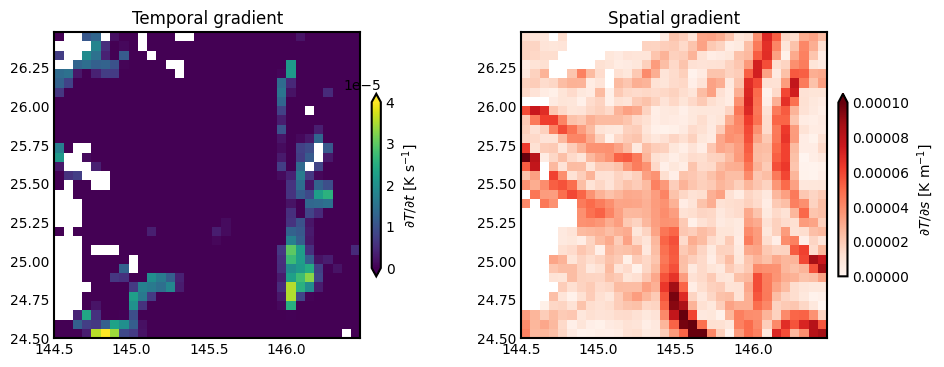

In [15]:
fig, ax = plots.plot_gradients(ds.isel(time=14), sg_names=['dTdx','dTdy'])

# Using the de Kreij code to make a GP prediction

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

---
# Run the parameter optimization

##### Running every 6 hours to demonstrate intermittent fitting

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [17]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

refit_time = np.timedelta64(6, 'h').astype('timedelta64[ns]')

results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(data_dir, f'{crop_app}_fits.nc'), callback="off")

Running GP optimization
Refitting hyperparameters
Saved results for time step 2025-05-12T00:00:00
Saved results for time step 2025-05-12T01:00:00
Saved results for time step 2025-05-12T02:00:00
Saved results for time step 2025-05-12T03:00:00
Saved results for time step 2025-05-12T04:00:00
Saved results for time step 2025-05-12T05:00:00
Refitting hyperparameters
Saved results for time step 2025-05-12T06:00:00
Saved results for time step 2025-05-12T07:00:00
Saved results for time step 2025-05-12T08:00:00
Saved results for time step 2025-05-12T09:00:00
Saved results for time step 2025-05-12T10:00:00
Saved results for time step 2025-05-12T11:00:00
Refitting hyperparameters
Saved results for time step 2025-05-12T12:00:00
Saved results for time step 2025-05-12T13:00:00
Saved results for time step 2025-05-12T14:00:00
Saved results for time step 2025-05-12T15:00:00
Saved results for time step 2025-05-12T16:00:00
Saved results for time step 2025-05-12T17:00:00
Refitting hyperparameters
Saved re

In [18]:
### Load the results
ds_results = xr.open_dataset(os.path.join(data_dir, f'{crop_app}_fits.nc'))
ds_results.close()
ds_results

<xarray.Dataset> Size: 2kB
Dimensions:    (time: 24)
Coordinates:
  * time       (time) datetime64[ns] 192B 2025-05-12 ... 2025-05-12T23:00:00
Data variables:
    sigma_u    (time) float64 192B ...
    l_u        (time) float64 192B ...
    tau_u      (time) float64 192B ...
    sigma_v    (time) float64 192B ...
    l_v        (time) float64 192B ...
    tau_v      (time) float64 192B ...
    sigma_S    (time) float64 192B ...
    l_S        (time) float64 192B ...
    tau_S      (time) float64 192B ...
    sigma_tau  (time) float64 192B ...

In [19]:
## Use parameters to make predictions
print("Calculating GP regression prediction")
ds_prediction = gpr.predict_series(ds.sel(time=ds_results.time), ds_results)
ds_prediction.to_netcdf(path=os.path.join(data_dir, f'{crop_app}_predictions.nc'))

### Load the data
ds_prediction = xr.open_dataset(os.path.join(data_dir, f'{crop_app}_predictions.nc'))

Calculating GP regression prediction


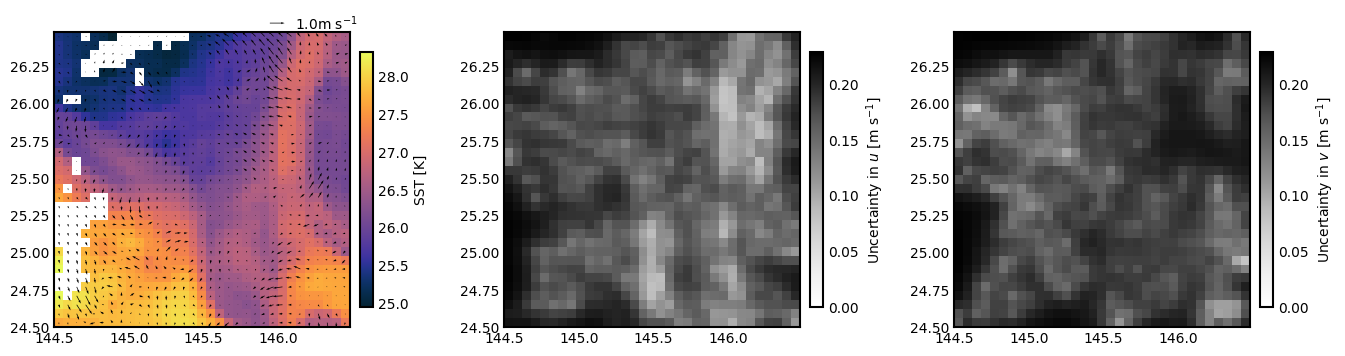

In [21]:
fig, ax = plots.plot_prediction(ds_prediction.isel(time=14), qk_size=1.)

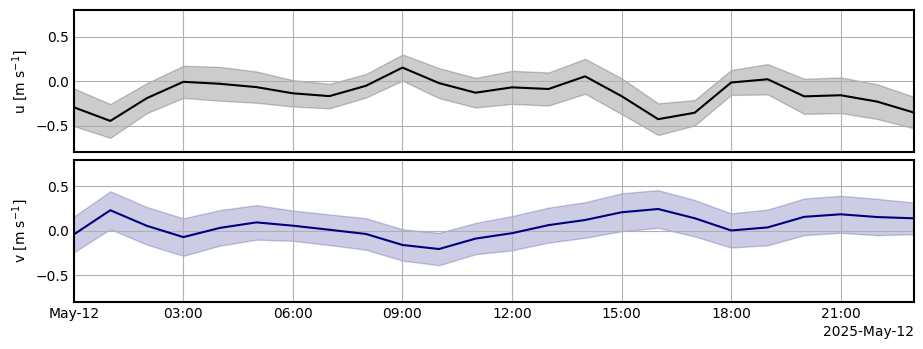

In [23]:
fig, ax = plots.plot_timeseries(ds_prediction, lon_pt=146.5, lat_pt=25.5)

In [25]:
from IPython.display import HTML
%matplotlib notebook

ani = plots.plot_prediction_animation(ds_prediction)
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>